In [3]:
import torch
import numpy as np
from matplotlib import pyplot as plt

In [4]:
measurement_sigma = np.sqrt(0.5);
process_noise = np.sqrt(0.1);
sensor_locations = np.array([[0,0],[3000,3000]]);

In [5]:
class bearing():
    def __init__(self,sensor_no,bearing,time):
        self.sensor_no = sensor_no #can be 0 or 1
        self.sensor_location = np.array([[0,0],[3000,3000]])[sensor_no]
        self.bearing = bearing
        self.time = time
        self.track_id = 0 #for multiple target evaluations

In [6]:
initial_positions = np.array([100,200])
initial_velocities = np.array(5) #m/s
initial_orientation = np.array([335])
dx = initial_velocities * np.cos(np.deg2rad(90 - initial_orientation))
dy = initial_velocities * np.sin(np.deg2rad(90 - initial_orientation))
ts = 1
print(dx)
print(dy)



[-2.11309131]
[4.53153894]


In [7]:
A = lambda Ts: np.array([[1, 0, Ts, 0],[0, 1, 0, Ts], [0, 0, 1, 0],[0, 0, 0, 1]])
B = lambda ts: np.concatenate(((ts**2)*0.5*np.eye(2), ts * np.eye(2)), axis = 0)
aci = lambda konum, sensor_no: np.rad2deg(np.arctan2(konum[0] - sensor_locations[sensor_no][0], konum[1] - sensor_locations[sensor_no][1]))

In [8]:
aci(konum,1)

NameError: name 'konum' is not defined

In [9]:
Ts=1

In [10]:
temp_time_array = np.linspace(0,100,100 / Ts)
time_array = np.sort(np.concatenate((temp_time_array, temp_time_array + np.random.rand(1,100) * 1/2), axis=None))
car_traj = [np.concatenate((initial_positions, dx, dy), axis=None)]
bearings = [bearing(0,aci(car_traj[0],1),time_array[0])]
for i in range(1,len(time_array)):
    car_traj.append((np.matmul(A(time_array[i]-time_array[i-1]),car_traj[-1].T).T + np.matmul(B(time_array[i]-time_array[i-1]), np.random.rand(2,1)).T * process_noise)[0])
coordinates = np.array(car_traj)[:,0:2]


In [11]:
for i in range(1,len(car_traj)):
    a = np.random.choice([False,True], p = [0.5,0.5])
    if a:
        bearings.append(bearing(0,aci(car_traj[i],0),time_array[i]))
    else:
        bearings.append(bearing(1,aci(car_traj[i],1),time_array[i])) 
        

In [12]:
bearings[34].bearing

-132.85799627815092

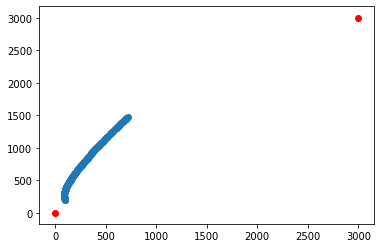

In [13]:
plt.scatter(coordinates[:,0],coordinates[:,1])
plt.scatter(sensor_locations[0][0],sensor_locations[0][1], c = "red")
plt.scatter(sensor_locations[1][0],sensor_locations[1][1], c = "red")

In [14]:
temp_time_array = np.linspace(0,100,100 / Ts)

In [15]:
def create_gaussian_particles(mean, std, N):
    particles = torch.empty((N, 3))
    particles[:, 0] = mean[0] + (torch.randn(N) * std[0])
    particles[:, 1] = mean[1] + (torch.randn(N) * std[1])
    particles[:, 2] = mean[2] + (torch.randn(N) * std[2])
    particles[:, 2] %= 2 * np.pi
    return particles

In [22]:
torch.distributions.multivariate_normal.MultivariateNormal(particles[0, 0:2], covariance_matrix=torch.diag(torch.FloatTensor([1,1]))).log_prob(torch.FloatTensor([1,1]))

tensor(-15.6248)

In [17]:
def update(particles, weights, z, R, landmarks):
    for i, landmark in enumerate(landmarks):
        distance = torch.norm(particles[:, 0:2] - landmark, dim=1)
        weigths *= torch.FloatTensor(10).pow(torch.distributions.multivariate_normal.MultivariateNormal(distance, covariance_matrix=R).log_prob(z[i]))

    weights += torch.Tensor([1.e-300])     # avoid round-off to zero
    weights /= sum(weights) # normalize

In [18]:
def predict(particles, u, std, dt=torch.Tensor([1.])):
    """ move according to control input u (heading change, velocity)
    with noise Q (std heading change, std velocity)`"""

    N = len(particles)
    # update heading
    particles[:, 2] += u[0] + (torch.randn(N) * std[0])
    particles[:, 2] %= torch.Tensor([2 * np.pi])

    # move in the (noisy) commanded direction
    dist = (u[1] * dt) + (torch.randn(N) * std[1])
    particles[:, 0] += torch.cos(particles[:, 2]) * dist
    particles[:, 1] += torch.sin(particles[:, 2]) * dist
    return particles

In [19]:
def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""

    pos = particles[:, 0:2]
    mean = torch.sum(torch.mul(pos,weights),dim=0)/torch.sum(weights)
    var = torch.sum(torch.mul((pos - mean).pow(2),weights),dim=0)/torch.sum(weights)
    return mean, var

In [20]:
def neff(weights):
    return 1. / torch.sum(torch.mul(weights,weights))

In [21]:
N = 30000
particles = create_gaussian_particles([4,3,1],[1,2,1], N)
weights = torch.ones(N,1)* 0.25
estimate(particles, weights)
neff(weights)

tensor(0.0005)